In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

In [2]:
RANDOM_STATE = 343

## Data Preparation

In [3]:
dat = pd.read_csv('features_lookback_10.csv')

# remove rows with low average fantasy points
dat_filtered = dat[dat.loc[:, 'FP_1':'FP_10'].mean(axis='columns')>20].drop(columns=['url_suffix', 'Date'])
dat_filtered = dat_filtered[dat_filtered['Salary']>=4500]

# split sets
X = dat_filtered.iloc[:, 1:]
y = dat_filtered.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)

# center and scale
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# feature names
names = dat.drop(columns=['url_suffix', 'Date', 'FP']).columns.to_list()

In [4]:
pp = pd.read_csv('player_positions.csv')
pp.head(1)

,Id,First Name,Last Name,Nickname,Position,PG,SG,SF,PF,C,url_suffix
0,59358,Domantas,Sabonis,Domantas Sabonis,C/PF,0,0,0,1,1,domantas-sabonis


In [5]:
m = dat.merge(
    right=pp[['url_suffix','PG', 'SG', 'SF', 'PF', 'C']],
    how='left', left_on='url_suffix', right_on='url_suffix'
)

m.head()

,url_suffix,Date,FP,Salary,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,...,Salary_6,Salary_7,Salary_8,Salary_9,Salary_10,PG,SG,SF,PF,C
0,a-j-green,4/10/24,4.0,3800.0,7.2,5.0,8.6,21.8,6.5,5.0,...,3700.0,3700.0,3700.0,3700.0,3700.0,0.0,1.0,0.0,0.0,0.0
1,a-j-green,4/9/24,7.2,3800.0,5.0,8.6,21.8,6.5,5.0,0.0,...,3700.0,3700.0,3700.0,3700.0,3800.0,0.0,1.0,0.0,0.0,0.0
2,a-j-green,4/7/24,5.0,3800.0,8.6,21.8,6.5,5.0,0.0,5.4,...,3700.0,3700.0,3700.0,3800.0,3600.0,0.0,1.0,0.0,0.0,0.0
3,a-j-green,4/5/24,8.6,3800.0,21.8,6.5,5.0,0.0,5.4,16.4,...,3700.0,3700.0,3800.0,3600.0,3600.0,0.0,1.0,0.0,0.0,0.0
4,a-j-green,4/3/24,21.8,3600.0,6.5,5.0,0.0,5.4,16.4,0.0,...,3700.0,3800.0,3600.0,3600.0,3700.0,0.0,1.0,0.0,0.0,0.0


In [6]:
m[m['C'].isnull()].drop_duplicates('url_suffix')

,url_suffix,Date,FP,Salary,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,...,Salary_6,Salary_7,Salary_8,Salary_9,Salary_10,PG,SG,SF,PF,C
441,aleksandar-vezenkov,4/16/24,1.2,3600.0,4.2,7.4,0.0,9.9,16.4,10.5,...,3800.0,3800.0,3700.0,3700.0,3700.0,NaN,NaN,NaN,NaN,NaN
6972,ishmael-smith,2/7/24,11.4,4400.0,23.4,10.6,9.7,6.0,4.5,24.6,...,4100.0,3900.0,3900.0,3700.0,3700.0,NaN,NaN,NaN,NaN,NaN
8652,jeenathan-williams,4/14/24,20.6,3500.0,0.0,4.4,6.4,3.5,0.0,10.6,...,3500.0,3500.0,3500.0,3500.0,3500.0,NaN,NaN,NaN,NaN,NaN
11757,lindy-waters-iii,4/14/24,18.0,3500.0,9.2,11.4,13.0,27.3,6.7,7.4,...,3500.0,3500.0,3500.0,3500.0,3500.0,NaN,NaN,NaN,NaN,NaN
15962,sviatoslav-mykhailiuk,4/12/24,13.6,3800.0,14.4,7.7,9.4,8.9,3.0,0.0,...,3700.0,3700.0,3700.0,3600.0,3600.0,NaN,NaN,NaN,NaN,NaN


## Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
reg = LinearRegression()

cv_scores = cross_val_score(reg, X_train_scaled, y_train, cv=kf)

print('Training score:', np.quantile(cv_scores, [.05, .95]))

Training score: [0.35378504 0.42353238]


## Ridge Regression

In [8]:
from sklearn.linear_model import Ridge

alphas = [.1, 1, 10, 100, 1000]
ridge_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)

    cv_scores = cross_val_score(ridge, X, y, cv=kf)
    print(f'alpha = {alpha} \tmean = {round(np.mean(cv_scores),3)} \tquantile = {np.quantile(cv_scores, [.5, .95])}')

    ridge_scores.append(cv_scores)    

alpha = 0.1 	mean = 0.392 	quantile = [0.3983033  0.42889736]
alpha = 1 	mean = 0.392 	quantile = [0.3983039  0.42889912]
alpha = 10 	mean = 0.392 	quantile = [0.39830983 0.42891656]
alpha = 100 	mean = 0.392 	quantile = [0.39836206 0.4290759 ]
alpha = 1000 	mean = 0.393 	quantile = [0.3985694  0.42989996]


## Kernel Ridge Regression

In [9]:
from sklearn.kernel_ridge import KernelRidge

kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
# rbf
kr_rbf = KernelRidge(kernel='rbf')

cv_scores = cross_val_score(kr_rbf, X_train_scaled, y_train, cv=kf)
print('RBF training score:', np.quantile(cv_scores, [.05, .95]))

# polynomial
kr_poly = KernelRidge(kernel='poly', degree=3)

cv_scores = cross_val_score(kr_poly, X_train_scaled, y_train, cv=kf)
print('Polynomial training score:', np.quantile(cv_scores, [.05, .95]))

RBF training score: [0.29877608 0.37983425]
Polynomial training score: [0.26987456 0.34720696]


## Model Comparison

In [10]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1),
    'RBF Kernel Ridge': KernelRidge(kernel='rbf'),
    'Poly Kernel Ridge': KernelRidge(kernel='poly', degree=3)
}
results = []
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

for model in models.values():
    results.append(cross_val_score(model, X_train_scaled, y_train, cv=kf))

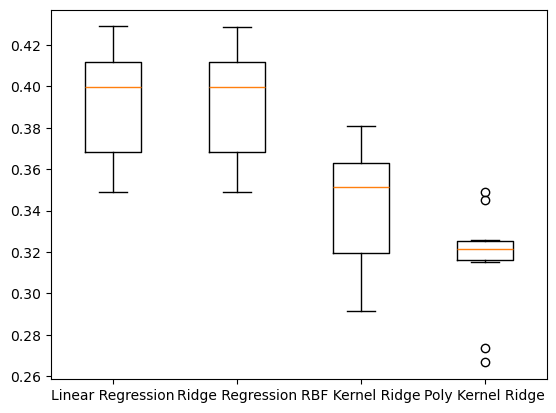

In [11]:
import matplotlib.pyplot as plt

plt.boxplot(results, labels=models.keys())
plt.show()